In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 13:41:30.129945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 13:41:31.646092: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 15500
end_idx = 15600
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(100, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(100, 96, 7)
(67200,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(100, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(100, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 13:41:40.660512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 13:41:43.571903: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 3ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step


4/4 [==============================] - 0s 4ms/step
CPU time: 2386.947086276952 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

4/4 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.35179002 0.27801664 0.79235522 ... 0.38206608 0.58765207 0.80265684]
Fitness value of the best solution = 0.017383107356386533


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

4/4 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


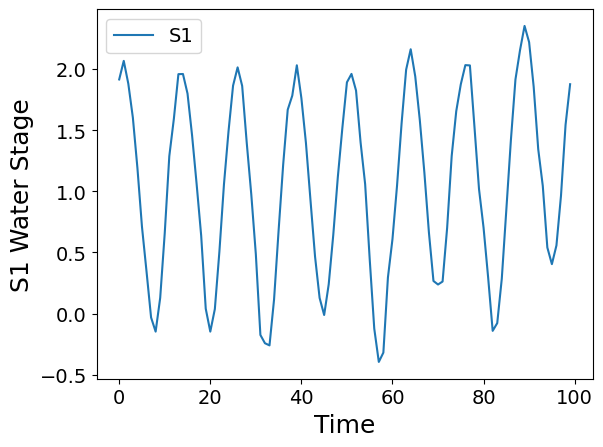

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low20.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.351790,0.278017,0.792355,0.716067,0.016435,0.120307,0.336308,0.447660,0.098827,0.434721,...,0.273308,0.194797,0.071466,0.153270,0.935503,0.318356,0.360206,0.521168,0.024223,0.048535
1,0.483121,0.606622,0.232689,0.462166,0.320823,0.590092,0.548252,0.169660,0.140629,0.201051,...,0.562706,0.195609,0.729577,0.040702,0.316240,0.965690,0.525466,0.331823,0.042288,0.168312
2,0.848392,0.116295,0.495458,0.558727,0.111979,0.903585,0.505033,0.588687,0.505385,0.708340,...,0.056114,0.462827,0.746673,0.051212,0.064885,0.662605,0.360320,0.572935,0.526042,0.435656
3,0.515619,0.273909,0.029351,0.591315,0.505734,0.836740,0.175375,0.545790,0.490083,0.662832,...,0.969281,0.170880,0.538785,0.554257,0.328496,0.709364,0.566549,0.307383,0.255041,0.053376
4,0.574691,0.491393,0.713289,0.507117,0.379319,0.594215,0.754580,0.467564,0.140492,0.029802,...,0.018019,0.387345,0.560609,0.915388,0.211026,0.753974,0.339715,0.747685,0.502097,0.761260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.594390,0.674149,0.324974,0.814491,0.439522,0.641546,0.072314,0.104735,0.923983,0.692312,...,0.810923,0.050392,0.279268,0.791606,0.554350,0.976294,0.847916,0.960596,0.148393,0.383647
96,0.309649,0.297637,0.007344,0.974539,0.080762,0.154362,0.571438,0.347595,0.109380,0.618097,...,0.553847,0.676261,0.394724,0.851582,0.993701,0.312371,0.012173,0.949781,0.053229,0.293466
97,0.268669,0.416144,0.037429,0.924254,0.508347,0.967747,0.297600,0.127510,0.130145,0.751593,...,0.367369,0.885320,0.631514,0.883418,0.601836,0.629131,0.630064,0.756875,0.929692,0.157818
98,0.298316,0.275688,0.729315,0.921258,0.435790,0.609050,0.107454,0.993879,0.504951,0.558419,...,0.271753,0.063759,0.820542,0.911973,0.228350,0.691425,0.489078,0.588016,0.320045,0.180076


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low20.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1.915065,1.836975,1.976426,1.996872,2.051788,2.151569,2.087460,2.155208,1.921584,1.800589,...,0.428665,0.300841,0.496398,0.721305,0.692795,0.696072,0.942519,0.930854,1.084503,1.076724
1,2.067029,2.127925,2.092970,2.056917,1.973291,2.115690,2.011579,2.050127,1.569651,1.397835,...,0.668259,0.946642,1.092305,0.928274,1.186455,1.490051,1.460846,1.281618,1.555903,1.789579
2,1.880321,1.825075,1.954164,2.080787,1.507918,1.384238,1.700852,1.734406,1.086249,1.277063,...,1.116701,1.036481,1.493226,1.615675,1.462756,1.498086,1.786476,1.690989,1.852289,1.951505
3,1.602928,1.736957,1.912852,1.701802,1.168432,0.993057,1.451874,1.316692,0.646787,0.544782,...,1.443067,1.592094,1.813771,1.775133,1.802290,1.914082,1.945679,2.093098,2.035774,2.124981
4,1.191255,1.271306,1.449520,1.384072,0.690717,0.725062,1.013375,0.852761,0.312504,0.225161,...,1.806370,1.875030,1.999710,2.188540,2.025420,2.126467,1.985500,2.192758,2.079471,2.121067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.404530,0.437070,0.537041,0.433368,0.477002,0.725690,0.535052,0.453956,0.955984,0.877201,...,2.069386,2.041407,1.616574,1.578123,1.767077,1.743639,1.173017,1.306579,1.511467,1.415023
96,0.557626,0.567327,0.730185,0.571457,0.972435,1.171869,0.998080,0.876604,1.585524,1.630848,...,1.561961,1.686082,1.060247,1.059014,1.301213,1.334478,0.800305,1.076489,1.002021,0.944322
97,0.964945,1.250047,1.043903,0.960257,1.500006,1.696971,1.399942,1.527824,1.880663,1.716774,...,1.203186,1.250025,0.741167,0.954977,1.040347,1.078947,0.663713,1.046043,0.976104,0.978207
98,1.543235,1.744733,1.563130,1.524840,1.892567,1.965404,1.856040,1.894300,2.219218,2.194433,...,0.998185,1.041657,0.531727,0.817679,0.697063,0.705513,0.671543,1.142429,0.822653,0.887814


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 386, areas: 47.68017003026034


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

4/4 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 1070, areas: 212.0461937012442
